In [1]:
import pandas as pd
# "The cleaning supply"
import re
import string
# "NLP Supply"
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

In [2]:
train = pd.read_csv('project_train.csv')
test = pd.read_csv('project_test.csv')

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
wordnet_lemmatizer = WordNetLemmatizer()
englishStemmer=SnowballStemmer("english")

def clean_text(x):
    temp_text = x.lower().replace('\u200b', '')
    temp_text = temp_text.translate(str.maketrans('', '', string.punctuation))
    temp_text = temp_text.replace('\n', '')
    temp_text = re.sub(' +', ' ', temp_text).strip()
    temp_text = nltk.word_tokenize(temp_text)
    stop_words = set(stopwords.words('english'))
    
    filtered_word = []
    
    for word in temp_text:
        lemma_word = wordnet_lemmatizer.lemmatize(word)
        stemmed_word = englishStemmer.stem(lemma_word)
        if stemmed_word in stop_words:
            continue
        else:
            filtered_word.append(stemmed_word)
            
    return " ".join(filtered_word).strip()

In [6]:
train['text'] = train['text'].apply(clean_text)
test['text'] = test['text'].apply(clean_text)

In [7]:
VAL_PERCENTAGE = 0.2
N_VAL = int(len(train) * VAL_PERCENTAGE)

# Shuffle train DataFrame also reset the shuffled index
train = train.sample(frac=1).reset_index(drop=True)

# Set validation DataFrame as having the first N_VAL row
val_data = train[:N_VAL]

# Set train DataFrame as the rest
train_data = train[N_VAL:]

In [8]:
val_data.describe()

,id,target
count,1522.000000,1522.000000
mean,5383.296321,0.414586
std,3119.317275,0.492812
min,4.000000,0.000000
25%,2684.000000,0.000000
50%,5285.500000,0.000000
75%,8061.500000,1.000000
max,10869.000000,1.000000


In [9]:
train_data.describe()

,id,target
count,6091.000000,6091.000000
mean,5456.587260,0.433426
std,3141.631925,0.495589
min,1.000000,0.000000
25%,2756.500000,0.000000
50%,5428.000000,0.000000
75%,8173.500000,1.000000
max,10873.000000,1.000000


In [10]:
validation_file_path = "./text.val"
training_file_path = "./text.train"

def append_fasttext_dataset(row, file_writer):
    def convert_row_to_dataset_string(row):
        return "__label__" + str(row['target']) + " " + row['text']
    
    file_writer.write(convert_row_to_dataset_string(row) + '\n')


In [11]:
with open(validation_file_path, 'a+') as writer:
    val_data.apply(lambda x: append_fasttext_dataset(x, writer), axis=1)
    
# Training file
with open(training_file_path, 'a+') as writer:
    train_data.apply(lambda x: append_fasttext_dataset(x, writer), axis=1)

<AxesSubplot:>

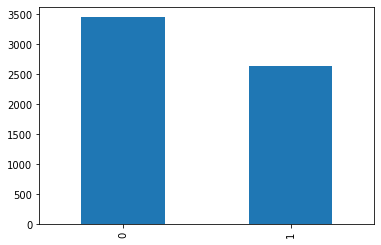

In [12]:
train_data['target'].value_counts().plot.bar()

<AxesSubplot:>

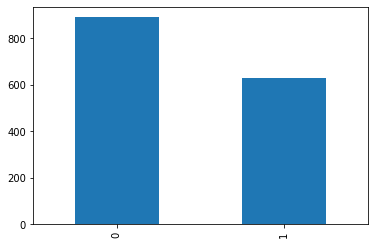

In [13]:
val_data['target'].value_counts().plot.bar()

In [14]:
import fasttext

In [15]:
hyper_params = {
    "lr": 0.01,
    "epoch": 15,
    "wordNgrams": 2,
    "dim": 20,
    "verbose": 1
}

In [16]:
model = fasttext.train_supervised(input=training_file_path, **hyper_params)

Read 0M words
Number of words:  19630
Number of labels: 2
Progress: 100.0% words/sec/thread: 2997287 lr:  0.000000 avg.loss:  0.384095 ETA:   0h 0m 0s


In [17]:
import matplotlib.pyplot as plt

In [18]:
model_autotuning_metrics = fasttext.train_supervised(input=training_file_path, **hyper_params_autotuning_metrics)

NameError: name 'hyper_params_autotuning_metrics' is not defined

In [ ]:
result = model.test(training_file_path)
validation = model.test(validation_file_path)

print("Result : ", result)
print("Validation : ", validation)

# Plot the result
accuracy_data = [result[1], validation[1]]
labels = ['Model Accuracy', 'Validation Accuracy']

plt.title("Model accuracy")
plt.bar(labels, accuracy_data)
plt.show()

In [ ]:
def get_predicted_rating(x, model):
    return int(model.predict(x)[0][0].split('__label__')[1])

In [ ]:
val_data['predicted'] = val_data['text'].apply(lambda x: get_predicted_rating(x, model))

In [23]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [24]:
confusion_labels = [1, 2, 3, 4, 5]
confusion_matrix_data = confusion_matrix(val_data["target"], val_data["predicted"], labels=confusion_labels)
normalised_confusion_matrix = confusion_matrix_data.astype('float') / confusion_matrix_data.sum(axis=1)[:, np.newaxis]

/var/folders/7k/1h8g8hq95s1508rrp6cxtpv40000gn/T/ipykernel_14041/12301028.py:3: RuntimeWarning: invalid value encountered in true_divide
  normalised_confusion_matrix = confusion_matrix_data.astype('float') / confusion_matrix_data.sum(axis=1)[:, np.newaxis]


[Text(0, 0.5, '1'),
 Text(0, 1.5, '2'),
 Text(0, 2.5, '3'),
 Text(0, 3.5, '4'),
 Text(0, 4.5, '5')]

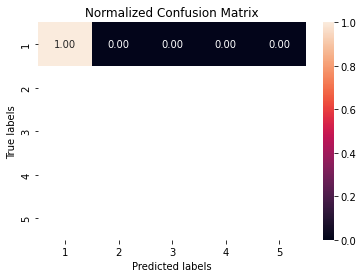

In [25]:
ax = plt.subplot()
sns.heatmap(normalised_confusion_matrix, annot=True, ax=ax, fmt='.2f');

ax.set_title('Normalized Confusion Matrix')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

ax.xaxis.set_ticklabels(confusion_labels)
ax.yaxis.set_ticklabels(confusion_labels)

In [26]:
hyper_params_autotuning = {
    "lr": 0.06,
    "epoch": 20,
    "wordNgrams": 2,
    "dim": 20,
    "verbose": 1,
    "autotuneValidationFile": validation_file_path
}

In [28]:
hyper_params_autotuning_metrics_5 = {
    "lr": 0.1,
    "epoch": model.epoch,
    "wordNgrams": 2,
    "dim": 50,
    "verbose": 2,
    "autotuneValidationFile": validation_file_path,
    "autotuneMetric": "f1:__label__5"
}

In [ ]:
model_autotuning_metrics_5 = fasttext.train_supervised(input=training_file_path, **hyper_params_autotuning_metrics_5)